In [45]:
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from keras.models import Model
from keras.layers import Input, Convolution1D, Flatten, Dense, Dropout, Embedding
from keras.optimizers import Adam,SGD
import tensorflow as tf
import nltk 
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize

In [46]:
#nltk.download() 

In [47]:
#Hyper Parameters
FILE_NAME = "../../Data/processed_data.csv"
DENSE_LAYER_SIZE =256
BATCH_SIZE = 32
EPOCH_LENGTH = 10
VALIDATION_PERCENTAGE = 0.1
TEST_SIZE_PERCENTAGE = 0.2
NUMBER_K_FOLDS = 3
LEARNING_RATE = 0.1
VERBOSE = 1
HIDDEN_ACTIVATION_FUNCTION = 'relu'
OUTPUT_ACTIVATION_FUNCTION = 'softmax'
LOSS_FUNCTION = 'categorical_crossentropy'
METRICS=['accuracy']
Y_LABEL_NAME="author"
X_LABEL_NAME="text"

In [48]:
#Defining model
def define_model(input_size, output_size, verbose = True, dense_layer_size = 50,
                 hidden_activation_fn = 'relu', output_activation_fn='softmax',
                 learning = 0.0005, loss_function = 'categorical_crossentropy', metrics = ['accuracy']):
    
    inputs = Input(shape = (input_size,1))
    dense1 = Convolution1D(filters = 100, kernel_size = 3, activation=hidden_activation_fn)(inputs)
    flat1 = Flatten()(dense1)

    output = Dense(units=output_size, activation=output_activation_fn)(flat1)
  
    
    # Create model
    model = Model(inputs = [inputs], outputs = [output])
    
    # Compile model
    model.compile(loss=loss_function, optimizer = SGD(learning_rate = learning), metrics=metrics)
    
    if verbose:
        print(model.summary())

    return model

In [49]:
#Read data
data = pd.read_csv(FILE_NAME)

In [50]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+') #

In [51]:
documents = data[X_LABEL_NAME]

# Go through all the documents and tokenize them by words
data_gensim = []
for doc in documents:
    # We are training on sentences
    for sentence in sent_tokenize(doc):
        tokens = []
        # We want only lower case
        for word in tokenizer.tokenize(sentence): # We are using the new tokeniser here
            tokens.append(word.lower())
        data_gensim .append(tokens)

# The result
print("Original doc: ", documents[0])
print("Tokenized doc: ", data_gensim[0])
print("Num Sentences: ", len(data_gensim))

Original doc:  This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
Tokenized doc:  ['this', 'process', 'however', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', 'as', 'i', 'might', 'make', 'its', 'circuit', 'and', 'return', 'to', 'the', 'point', 'whence', 'i', 'set', 'out', 'without', 'being', 'aware', 'of', 'the', 'fact', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall']
Num Sentences:  20019


In [52]:
tokenized_data = documents

In [53]:
EMB_DIM = 300
w2v = Word2Vec(tokenized_data,vector_size=EMB_DIM,window=5,min_count=3,negative=15)

In [54]:
word_vectors = w2v.wv

In [55]:
# Helper function to transform a document into a mean of the word vectors. 

# Note!! You should add your code in this function to implement Q1-5
def embedding_transform(documents_tokenized, w2v_model, embedding_size, transform_type='mean'):
    transformed_docs = []
    for words in documents_tokenized:
        transformed_doc = []
        for w in words:
            if w in w2v_model:
                transformed_doc.append(w2v_model[w])
            else:
                transformed_doc.append(np.zeros(embedding_size)) ## Add a default 0 vector for unknown words
        
        # How do you transform to a document? Put your answer in here. 
        if  transform_type == 'mean':
            transformed_doc = np.mean(transformed_doc, axis=0)
        transformed_docs.append(transformed_doc)
    output = np.array(transformed_docs)
    return output

In [56]:
#Get corpus and y label
text = data[X_LABEL_NAME]
author = data[Y_LABEL_NAME]

In [57]:
#Split data
text_train, text_test, author_train, author_test = train_test_split(text, author, test_size = TEST_SIZE_PERCENTAGE, random_state = 5)

In [58]:
X_train= embedding_transform(text_train, word_vectors, EMB_DIM, transform_type='mean')

In [59]:
X_test= embedding_transform(text_test, word_vectors, EMB_DIM, transform_type='mean')

In [60]:

#Get input and output dimensions
input_size = X_train.shape[1]
output_size = len(author.unique())

In [61]:
# One hot encode y labels
author_lb = LabelBinarizer()
author_lb.fit(author_train)
author_train_hot = author_lb.transform(author_train)
author_test_hot = author_lb.transform(author_test)

In [62]:
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(author_train))
print(np.shape(author_test))

(15663, 300)
(3916, 300)
(15663,)
(3916,)


In [63]:
# X_train = X_train[:,None]
# X_test = X_test[:,None]

X_train = X_train[:None,]
X_test = X_test[:None,]

In [64]:
print(np.shape(X_train))
print(np.shape(X_test))

(15663, 300)
(3916, 300)


In [65]:
# X_train = np.reshape(X_train,( -1,23230,1))
# X_test= np.reshape(X_test,( -1,23230,1))

# X_train = np.reshape(X_train,( -1,1,23230))
# X_test= np.reshape(X_test,( -1,1,23230))

In [66]:
# Sets seed
np.random.seed(28)
kf = KFold(n_splits = NUMBER_K_FOLDS)

test_accuracy_list = []
prec_list = []
recall_list = []
f1_list = []
training_time_list = []
prediction_time_list = []
full_history =[]

run = 0


for train_inds, _ in kf.split(X_train):
    run += 1
    print('Run:', run)
       
    train_x = np.array([X_train[i] for i in train_inds])
    train_y = np.array([author_train_hot[i] for i in train_inds])
       
    t0 = time.time()
    # Fit model
    cnn_model = define_model(input_size= input_size, output_size= output_size, verbose = False,
                      dense_layer_size = DENSE_LAYER_SIZE, hidden_activation_fn = HIDDEN_ACTIVATION_FUNCTION,
                      output_activation_fn = OUTPUT_ACTIVATION_FUNCTION, learning=LEARNING_RATE, loss_function = LOSS_FUNCTION, metrics=METRICS)

    histroy = cnn_model.fit(train_x, train_y, epochs=EPOCH_LENGTH, batch_size=BATCH_SIZE, verbose = VERBOSE,validation_split = VALIDATION_PERCENTAGE)
  
    t1 = time.time()
    
    # Predict values for test set
    author_pred1 = cnn_model.predict(X_test)
    author_pred1 = author_lb.inverse_transform(author_pred1)

    t2 = time.time()

    # Evaluate
    test_accuracy = accuracy_score(author_test, author_pred1)
    precision, recall, f1, support = score(author_test, author_pred1)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    training_time = (t1 - t0)
    prediction_time = (t2 - t1)
    
    test_accuracy_list.append(test_accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)
    training_time_list.append(training_time)
    prediction_time_list.append(prediction_time)
    full_history.append(histroy)

print("Test Accuracy:", test_accuracy_list)
print("Ave. Precision:", prec_list)
print("Ave. Recall:", recall_list)
print("Ave. F1 Score:", f1_list)

Run: 1
Epoch 1/10
294/294 [==============================] - 2s 5ms/step - loss: 1.0903 - accuracy: 0.3983 - val_loss: 1.0903 - val_accuracy: 0.3962
Epoch 2/10
294/294 [==============================] - 1s 5ms/step - loss: 1.0889 - accuracy: 0.4004 - val_loss: 1.0889 - val_accuracy: 0.3962
Epoch 3/10
294/294 [==============================] - 1s 5ms/step - loss: 1.0870 - accuracy: 0.3992 - val_loss: 1.0937 - val_accuracy: 0.3962
Epoch 4/10
294/294 [==============================] - 1s 5ms/step - loss: 1.0856 - accuracy: 0.4011 - val_loss: 1.0884 - val_accuracy: 0.3952
Epoch 5/10
294/294 [==============================] - 1s 5ms/step - loss: 1.0844 - accuracy: 0.4019 - val_loss: 1.0844 - val_accuracy: 0.3962
Epoch 6/10
294/294 [==============================] - 1s 5ms/step - loss: 1.0829 - accuracy: 0.4002 - val_loss: 1.0890 - val_accuracy: 0.3962
Epoch 7/10
294/294 [==============================] - 1s 5ms/step - loss: 1.0805 - accuracy: 0.4017 - val_loss: 1.0821 - val_accuracy: 0.3962

In [67]:
#Get averages for kfold runs
mean_accuracy_across_kfold = np.mean(test_accuracy_list)
mean_percision_across_kfold = np.mean(prec_list)
mean_recall_across_kfold = np.mean(recall_list)
mean_f1_across_kfold = np.mean(f1_list)


print("Average Accuracy across K-folds:", mean_accuracy_across_kfold)
print("Average Precision across K-folds:", mean_percision_across_kfold)
print("Average Recall across K-folds:", mean_recall_across_kfold)
print("Average F1 Score across K-folds:", mean_f1_across_kfold)
print("Average Training Time across K-folds:", (t1 - t0), "seconds")
print("Prediction Time across K-folds:", (t2 - t1), "seconds")

Average Accuracy across K-folds: 0.42390194075587334
Average Precision across K-folds: 0.4434064104766317
Average Recall across K-folds: 0.42390194075587334
Average F1 Score across K-folds: 0.29581571194713124
Average Training Time across K-folds: 14.47100019454956 seconds
Prediction Time across K-folds: 0.3339998722076416 seconds


In [68]:
average_test_loss_accross_kfold = []
average_validation_loss_accross_kfold = []
average_test_accuracy_accross_kfold = []
average_validation_accuracy_accross_kfold = []

for i in range(len(full_history)):
    average_test_loss_accross_kfold.append(full_history[i].history['loss'])
    average_validation_loss_accross_kfold.append(full_history[i].history['val_loss'])

    average_test_accuracy_accross_kfold.append(full_history[i].history['accuracy'])
    average_validation_accuracy_accross_kfold.append(full_history[i].history['val_accuracy'])

average_loss_accross_kfold = np.mean(average_test_loss_accross_kfold,axis=0)
average_validation_loss_accross_kfold = np.mean(average_validation_loss_accross_kfold,axis=0)

average_accuracy_accross_kfold = np.mean(average_test_accuracy_accross_kfold,axis=0)
average_validation_accuracy_accross_kfold = np.mean(average_validation_accuracy_accross_kfold,axis=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


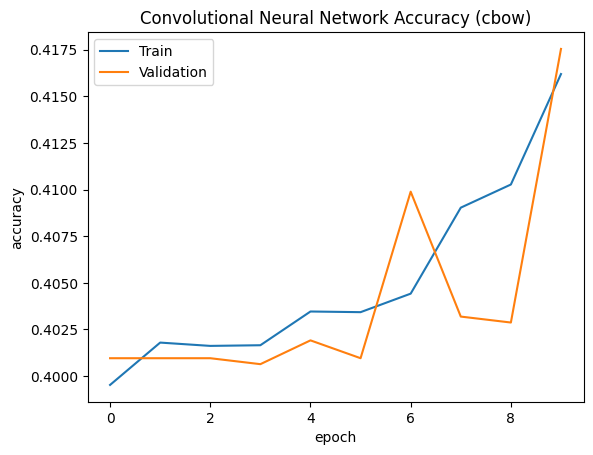

In [69]:
# summarize history for accuracy
plt.plot(average_accuracy_accross_kfold)
plt.plot(average_validation_accuracy_accross_kfold)
plt.title('Convolutional Neural Network Accuracy (cbow)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("../outputs/Convolutional_neural_network_cbow_acc.eps", format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


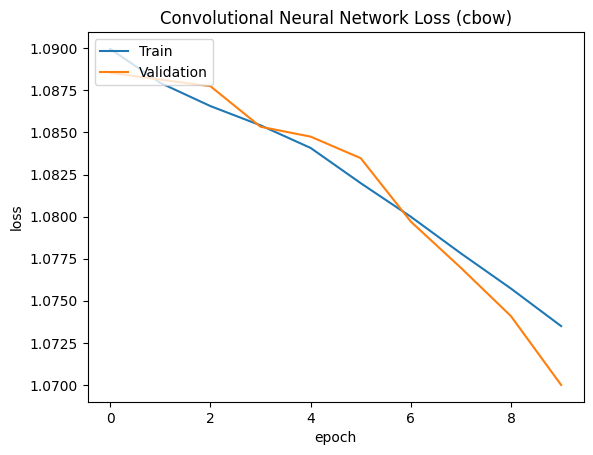

In [70]:
# summarize history for loss
plt.plot(average_loss_accross_kfold)
plt.plot(average_validation_loss_accross_kfold)
plt.title('Convolutional Neural Network Loss (cbow)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("../outputs/Convolutional_neural_network__cbow_loss.eps", format='eps')
plt.show()